In [2]:
# import library crawling
import tweepy
import csv
import string
import pandas as pd

# import library preprocessing
import ast 
import re #regex library
import preprocessor as p
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('corpus')
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter

# import library naive bayes clasifier
import numpy as np
import joblib
import pickle
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_score
import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import seaborn as sns

[nltk_data] Downloading package punkt to C:\Users\RIDHO-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\RIDHO-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading corpus: Package 'corpus' not found in index


# Crawling Data

In [90]:
#autentikasi
consumer_key = "GKtBQUKG9P7gPb629k4VTXYLR"
consumer_secret = "sIy9UnygHFNNm10JJ39Nc63UNM6VFG4lfZaRVpmF9nguK031LW"
access_token = "1191685350994767872-CnsLMvZxxDqdOMdSwRBx7LPvoG7zKl"
access_token_secret = "fblIxURhznuMKB8d9cIPHLcHqBEZZog3fNG4FDnjIzDk0"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [91]:
def scraptweets(search_words, date_since, date_until):

    db_tweets = pd.DataFrame(columns=['username', 'tweetcreatedts', 'tweet'])

    tweets = tweepy.Cursor(
                    api.search_tweets, q=search_words, lang="id", 
                    since=date_since, until=date_until, tweet_mode='extended').items(1000)

    tweet_list = [tweet for tweet in tweets]

    for tweet in tweet_list:
        username = tweet.user.screen_name
        tweetcreatedts = tweet.created_at

        try:
            tweet = tweet.retweeted_status.full_text
        except AttributeError:
            tweet = tweet.full_text

        ith_tweet = [username, tweetcreatedts, tweet]

        db_tweets.loc[len(db_tweets)] = ith_tweet
    
    print('Proses Crawling Selesai, Total Data Sebanyak', len(db_tweets))
    filename = 'dataset uji/dataset-crawling.csv'
    db_tweets.to_csv(filename, index=False)

### Masukkan kata kunci dan rentang waktu 

In [93]:
search_words = "Sekolah offline -filter:retweets"
date_since = "2022-07-14"
date_until = "2022-07-18"

scraptweets(search_words, date_since, date_until)

Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since


Proses Crawling Selesai, Total Data Sebanyak 233


In [94]:
data_twt = pd.read_csv("dataset uji/dataset-crawling.csv")

In [98]:
data_twt = pd.read_csv("dataset/dataset-Nolabel-1200.csv")

In [99]:
# data_twt = pd.read_csv("dataset/dataset 2022/sekolah offline-13juni2022.csv")

In [100]:
data_twt

,username,tweetcreatedts,tweet
0,cemilih,2022-05-28 19:38:20,"kalo udah mulai normal lagi, udah pada sekolah..."
1,JUNGJIES,2022-05-28 17:46:37,"pdhl brg2 jg glama pas msh offline, tau2 sekol..."
2,collegemenfess,2022-05-28 16:51:24,[cm] kalo sidang offline berkas² pas penelitia...
3,lykygsgf,2022-05-28 16:19:47,"@subschfess campur². ada senengnya, cnth kl ke..."
4,achteezers,2022-05-28 16:06:04,gue dulu pacaran uwunya masih era offline nder...
...,...,...,...
1195,chocookyuu,2022-07-16 05:41:14+00:00,sekolah ku udah mulai offline dari maret dann ...
1196,enhypqn,2022-07-16 04:14:38+00:00,mana udah offline sekolah
1197,jjwerutoo,2022-07-16 03:46:29+00:00,gue kira senin bakal sekolah offline ternyata ...
1198,artistsbase,2022-07-16 02:58:29+00:00,art! curhat dkit sender akhir2 ini capek bgt s...


# Preprocessing

## Case Folding

In [101]:
data_twt['tweet_cf'] = data_twt['tweet'].str.lower()

print('Case Folding Result : \n')
print(data_twt['tweet_cf'].head(5))
print('\n\n\n')

Case Folding Result : 

0    kalo udah mulai normal lagi, udah pada sekolah...
1    pdhl brg2 jg glama pas msh offline, tau2 sekol...
2    [cm] kalo sidang offline berkas² pas penelitia...
3    @subschfess campur². ada senengnya, cnth kl ke...
4    gue dulu pacaran uwunya masih era offline nder...
Name: tweet_cf, dtype: object






## Tokenizing

In [102]:
def remove_tweet_special(text):
    # menghapus tab, new line, dan back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # menghapus non ASCII (emotikon, tulisan china, dll)
    text = text.encode('ascii', 'replace').decode('ascii')
    # menghapus mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # menghapus URL yg tidak lengkap
    return text.replace("http://", " ").replace("https://", " ")
                
data_twt['tweet_cf'] = data_twt['tweet_cf'].apply(remove_tweet_special)

#menghapus nomor
def remove_number(text):
    return  re.sub(r"\d+", "", text)

data_twt['tweet_cf'] = data_twt['tweet_cf'].apply(remove_number)

#menghapus tanda baca
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

data_twt['tweet_cf'] = data_twt['tweet_cf'].apply(remove_punctuation)

#menghapus spasi awal dan akhir
def remove_whitespace_LT(text):
    return text.strip()

data_twt['tweet_cf'] = data_twt['tweet_cf'].apply(remove_whitespace_LT)

#menghapus spasi yg dobel menjadi satu spasi
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

data_twt['tweet_cf'] = data_twt['tweet_cf'].apply(remove_whitespace_multiple)

# menghapus karakter tunggal
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

data_twt['tweet_clean'] = data_twt['tweet_cf'].apply(remove_singl_char)

def preprocessing_data(x):
    return p.clean(x)

data_twt['tweet_clean'] = data_twt['tweet_cf'].apply(preprocessing_data)

def tokenize_data(x):
    return p.tokenize(x)

data_twt['tweet_clean'] = data_twt['tweet_clean'].apply(tokenize_data)

In [103]:
alay_dict = pd.read_csv('kamus/kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

data_twt['tweet_clean_alay'] = data_twt['tweet_clean'].apply(normalize_alay) 
data_twt.drop_duplicates(keep=False,inplace=True)

In [104]:
def word_tokenize_wrapper(text):
    return word_tokenize(text)

data_twt['tweet_token'] = data_twt['tweet_clean_alay'].apply(word_tokenize_wrapper)

## Stopword Removal

In [105]:
from nltk.corpus import stopwords
print(set(stopwords.words('Indonesian')))

{'masing', 'kedua', 'sejak', 'begini', 'awalnya', 'keseluruhannya', 'sekali-kali', 'sudah', 'jawaban', 'oleh', 'terakhir', 'penting', 'seperlunya', 'asal', 'tetap', 'adanya', 'belakang', 'diingatkan', 'memberi', 'sebelumnya', 'sebaiknya', 'terjadinya', 'yakin', 'mereka', 'harusnya', 'karenanya', 'menghendaki', 'lamanya', 'inikah', 'jangankan', 'sebagaimana', 'tanpa', 'kalian', 'dikarenakan', 'toh', 'menyangkut', 'dibuat', 'bagaikan', 'akhir', 'saya', 'dia', 'dapat', 'sejauh', 'mempertanyakan', 'tandasnya', 'memulai', 'rasa', 'dituturkannya', 'dong', 'diinginkan', 'menanti', 'semisalnya', 'luar', 'menunjuki', 'dikira', 'tanyanya', 'antaranya', 'ditunjukkannya', 'buat', 'menunjuk', 'ibu', 'seluruhnya', 'semisal', 'berlalu', 'dini', 'jadilah', 'jikalau', 'tiap', 'bulan', 'membuat', 'semasa', 'seperti', 'ditegaskan', 'semampunya', 'rata', 'kelihatannya', 'sebab', 'mula', 'sebutlah', 'bagaimanakah', 'hal', 'bukanlah', 'bekerja', 'ingat', 'tunjuk', 'juga', 'selanjutnya', 'kami', 'hampir', 'd

In [106]:
# list stopword indonesia dari library nltk
list_stopwords = stopwords.words('indonesian')
print(len(list_stopwords))

# menambah stopword manual
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo', 
                       'kalo', 'amp', 'biar', 'bikin', 'bilang', 
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't', 
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah'])
len(list_stopwords)

# menambah stopword dari file luar
txt_stopword = pd.read_csv("kamus/stopword.csv", names= ["stopwords"], header = None)

# konversi stopword string ke list dan menambah stopword tambahan
list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))
len(list_stopwords)
# ---------------------------------------------------------------------------------------

# konversi list to dictionary
list_stopwords = set(list_stopwords)


#menghapus stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

data_twt['tweet_stopword'] = data_twt['tweet_token'].apply(stopwords_removal) 


print(data_twt['tweet_stopword'])

758
0       [normal, sekolah, kuliah, offline, full, wfo, ...
1       [barang, glama, pas, offline, sekolah, online,...
2       [sidang, offline, berkas, pas, penelitian, pak...
3       [campur, senengnya, cnth, ketemu, crush, sekol...
4       [gue, pacaran, uwunya, era, offline, nder, jar...
                              ...                        
1195    [sekolah, ku, offline, maret, enak, offline, o...
1196                                   [offline, sekolah]
1197               [gue, senin, sekolah, offline, online]
1198    [art, curhat, dkit, sender, cape, banget, seko...
1199    [kelas, dibolehin, sekolah, offline, gue, kete...
Name: tweet_stopword, Length: 1200, dtype: object


In [107]:
# normalisasi kata

def normalisasi(tweet):
    kamus_slangword = eval(open("kamus/combined_slang_words.txt").read()) # Membuka dictionary slangword
    pattern = re.compile(r'\b( ' + '|'.join (kamus_slangword.keys())+r')\b') # Search pola kata (contoh kpn -> kapan)
    content = []
    for kata in tweet:
        filteredSlang = pattern.sub(lambda x: kamus_slangword[x.group()],kata) # Replace slangword berdasarkan pola review yg telah ditentukan
        content.append(filteredSlang.lower())
    tweet = content
    return tweet
data_twt['tweet_normalisasi'] = data_twt['tweet_stopword'].apply(normalisasi)
print(data_twt['tweet_normalisasi'])

0       [normal, sekolah, kuliah, offline, full, wfo, ...
1       [barang, glama, pas, offline, sekolah, daring,...
2       [sidang, offline, berkas, pas, penelitian, pak...
3       [campur, senengnya, contoh, ketemu, crush, sek...
4       [saya, pacaran, uwunya, era, offline, nder, ja...
                              ...                        
1195    [sekolah, ku, offline, maret, enak, offline, d...
1196                                   [offline, sekolah]
1197              [saya, senin, sekolah, offline, daring]
1198    [art, curhat, dkit, sender, capek, banget, sek...
1199    [kelas, dibolehin, sekolah, offline, saya, ket...
Name: tweet_normalisasi, Length: 1200, dtype: object


## Stemming

In [108]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in data_twt['tweet_normalisasi']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
            
print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

data_twt['tweet_stemming'] = data_twt['tweet_normalisasi'].swifter.apply(get_stemmed_term)
print(data_twt['tweet_stemming'])

3616
------------------------


Pandas Apply:   0%|          | 0/1200 [00:00<?, ?it/s]

0       [normal, sekolah, kuliah, offline, full, wfo, ...
1       [barang, glama, pas, offline, sekolah, daring,...
2       [sidang, offline, berkas, pas, teliti, pakai, ...
3       [campur, neng, contoh, ketemu, crush, sekolah,...
4       [saya, pacar, uwunya, era, offline, nder, jara...
                              ...                        
1195    [sekolah, ku, offline, maret, enak, offline, d...
1196                                   [offline, sekolah]
1197              [saya, senin, sekolah, offline, daring]
1198    [art, curhat, dkit, sender, capek, banget, sek...
1199    [kelas, dibolehin, sekolah, offline, saya, ket...
Name: tweet_stemming, Length: 1200, dtype: object


In [109]:
df = pd.DataFrame(data_twt)
df['tweet_stemming'] = df['tweet_stemming'].apply(str)

In [110]:
def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])
data_twt["tweet_bersih"] = data_twt["tweet_stemming"].apply(join_text_list)

In [111]:
data_twt

,username,tweetcreatedts,tweet,tweet_cf,tweet_clean,tweet_clean_alay,tweet_token,tweet_stopword,tweet_normalisasi,tweet_stemming,tweet_bersih
0,cemilih,2022-05-28 19:38:20,"kalo udah mulai normal lagi, udah pada sekolah...",kalo udah mulai normal lagi udah pada sekolah ...,kalo udah mulai normal lagi udah pada sekolah ...,kalau sudah mulai normal lagi sudah pada sekol...,"[kalau, sudah, mulai, normal, lagi, sudah, pad...","[normal, sekolah, kuliah, offline, full, wfo, ...","[normal, sekolah, kuliah, offline, full, wfo, ...","['normal', 'sekolah', 'kuliah', 'offline', 'fu...",normal sekolah kuliah offline full wfo gakebay...
1,JUNGJIES,2022-05-28 17:46:37,"pdhl brg2 jg glama pas msh offline, tau2 sekol...",pdhl brg jg glama pas msh offline tau sekolah ...,pdhl brg jg glama pas msh offline tau sekolah ...,padahal barang juga glama pas masih offline ta...,"[padahal, barang, juga, glama, pas, masih, off...","[barang, glama, pas, offline, sekolah, online,...","[barang, glama, pas, offline, sekolah, daring,...","['barang', 'glama', 'pas', 'offline', 'sekolah...",barang glama pas offline sekolah daring teman ...
2,collegemenfess,2022-05-28 16:51:24,[cm] kalo sidang offline berkas² pas penelitia...,cm kalo sidang offline berkas pas penelitian t...,cm kalo sidang offline berkas pas penelitian t...,cuma kalau sidang offline berkas pas penelitia...,"[cuma, kalau, sidang, offline, berkas, pas, pe...","[sidang, offline, berkas, pas, penelitian, pak...","[sidang, offline, berkas, pas, penelitian, pak...","['sidang', 'offline', 'berkas', 'pas', 'teliti...",sidang offline berkas pas teliti pakai bawa te...
3,lykygsgf,2022-05-28 16:19:47,"@subschfess campur². ada senengnya, cnth kl ke...",campur ada senengnya cnth kl ketemu crush di s...,campur ada senengnya cnth kl ketemu crush di s...,campur ada senengnya cnth kalau ketemu crush d...,"[campur, ada, senengnya, cnth, kalau, ketemu, ...","[campur, senengnya, cnth, ketemu, crush, sekol...","[campur, senengnya, contoh, ketemu, crush, sek...","['campur', 'neng', 'contoh', 'ketemu', 'crush'...",campur neng contoh ketemu crush sekolah jiakh ...
4,achteezers,2022-05-28 16:06:04,gue dulu pacaran uwunya masih era offline nder...,gue dulu pacaran uwunya masih era offline nder...,gue dulu pacaran uwunya masih era offline nder...,gue dulu pacaran uwunya masih era offline nder...,"[gue, dulu, pacaran, uwunya, masih, era, offli...","[gue, pacaran, uwunya, era, offline, nder, jar...","[saya, pacaran, uwunya, era, offline, nder, ja...","['saya', 'pacar', 'uwunya', 'era', 'offline', ...",saya pacar uwunya era offline nder jarang post...
...,...,...,...,...,...,...,...,...,...,...,...
1195,chocookyuu,2022-07-16 05:41:14+00:00,sekolah ku udah mulai offline dari maret dann ...,sekolah ku udah mulai offline dari maret dann ...,sekolah ku udah mulai offline dari maret dann ...,sekolah ku sudah mulai offline dari maret dan ...,"[sekolah, ku, sudah, mulai, offline, dari, mar...","[sekolah, ku, offline, maret, enak, offline, o...","[sekolah, ku, offline, maret, enak, offline, d...","['sekolah', 'ku', 'offline', 'maret', 'enak', ...",sekolah ku offline maret enak offline daring t...
1196,enhypqn,2022-07-16 04:14:38+00:00,mana udah offline sekolah,mana udah offline sekolah,mana udah offline sekolah,mana sudah offline sekolah,"[mana, sudah, offline, sekolah]","[offline, sekolah]","[offline, sekolah]","['offline', 'sekolah']",offline sekolah
1197,jjwerutoo,2022-07-16 03:46:29+00:00,gue kira senin bakal sekolah offline ternyata ...,gue kira senin bakal sekolah offline ternyata ...,gue kira senin bakal sekolah offline ternyata ...,gue kira senin bakal sekolah offline ternyata ...,"[gue, kira, senin, bakal, sekolah, offline, te...","[gue, senin, sekolah, offline, online]","[saya, senin, sekolah, offline, daring]","['saya', 'senin', 'sekolah', 'offline', 'daring']",saya senin sekolah offline daring
1198,artistsbase,2022-07-16 02:58:29+00:00,art! curhat dkit sender akhir2 ini capek bgt s...,art curhat dkit sender akhir ini cap

# Naive Bayes Classifier

In [112]:
with open('model/model_analisis.pkl', 'rb') as r:
    model_predict = pickle.load(r)

with open('model/tfidf.pkl', 'rb') as t:
    model_tfidf = pickle.load(t)

In [113]:
# with open('model/model_analisis.pkl', 'rb') as r:
#     model_predict = pickle.load(r)

# with open('model/count_vector.pkl', 'rb') as t:
#     model_tfidf = pickle.load(t)

In [114]:
transform_tfidf = model_tfidf.transform(data_twt['tweet_bersih'])

In [115]:
predictDataset = model_predict.predict(transform_tfidf)
data_twt['label_prediksi'] = predictDataset

In [116]:
data_twt

,username,tweetcreatedts,tweet,tweet_cf,tweet_clean,tweet_clean_alay,tweet_token,tweet_stopword,tweet_normalisasi,tweet_stemming,tweet_bersih,label_prediksi
0,cemilih,2022-05-28 19:38:20,"kalo udah mulai normal lagi, udah pada sekolah...",kalo udah mulai normal lagi udah pada sekolah ...,kalo udah mulai normal lagi udah pada sekolah ...,kalau sudah mulai normal lagi sudah pada sekol...,"[kalau, sudah, mulai, normal, lagi, sudah, pad...","[normal, sekolah, kuliah, offline, full, wfo, ...","[normal, sekolah, kuliah, offline, full, wfo, ...","['normal', 'sekolah', 'kuliah', 'offline', 'fu...",normal sekolah kuliah offline full wfo gakebay...,positif
1,JUNGJIES,2022-05-28 17:46:37,"pdhl brg2 jg glama pas msh offline, tau2 sekol...",pdhl brg jg glama pas msh offline tau sekolah ...,pdhl brg jg glama pas msh offline tau sekolah ...,padahal barang juga glama pas masih offline ta...,"[padahal, barang, juga, glama, pas, masih, off...","[barang, glama, pas, offline, sekolah, online,...","[barang, glama, pas, offline, sekolah, daring,...","['barang', 'glama', 'pas', 'offline', 'sekolah...",barang glama pas offline sekolah daring teman ...,negatif
2,collegemenfess,2022-05-28 16:51:24,[cm] kalo sidang offline berkas² pas penelitia...,cm kalo sidang offline berkas pas penelitian t...,cm kalo sidang offline berkas pas penelitian t...,cuma kalau sidang offline berkas pas penelitia...,"[cuma, kalau, sidang, offline, berkas, pas, pe...","[sidang, offline, berkas, pas, penelitian, pak...","[sidang, offline, berkas, pas, penelitian, pak...","['sidang', 'offline', 'berkas', 'pas', 'teliti...",sidang offline berkas pas teliti pakai bawa te...,positif
3,lykygsgf,2022-05-28 16:19:47,"@subschfess campur². ada senengnya, cnth kl ke...",campur ada senengnya cnth kl ketemu crush di s...,campur ada senengnya cnth kl ketemu crush di s...,campur ada senengnya cnth kalau ketemu crush d...,"[campur, ada, senengnya, cnth, kalau, ketemu, ...","[campur, senengnya, cnth, ketemu, crush, sekol...","[campur, senengnya, contoh, ketemu, crush, sek...","['campur', 'neng', 'contoh', 'ketemu', 'crush'...",campur neng contoh ketemu crush sekolah jiakh ...,negatif
4,achteezers,2022-05-28 16:06:04,gue dulu pacaran uwunya masih era offline nder...,gue dulu pacaran uwunya masih era offline nder...,gue dulu pacaran uwunya masih era offline nder...,gue dulu pacaran uwunya masih era offline nder...,"[gue, dulu, pacaran, uwunya, masih, era, offli...","[gue, pacaran, uwunya, era, offline, nder, jar...","[saya, pacaran, uwunya, era, offline, nder, ja...","['saya', 'pacar', 'uwunya', 'era', 'offline', ...",saya pacar uwunya era offline nder jarang post...,positif
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,chocookyuu,2022-07-16 05:41:14+00:00,sekolah ku udah mulai offline dari maret dann ...,sekolah ku udah mulai offline dari maret dann ...,sekolah ku udah mulai offline dari maret dann ...,sekolah ku sudah mulai offline dari maret dan ...,"[sekolah, ku, sudah, mulai, offline, dari, mar...","[sekolah, ku, offline, maret, enak, offline, o...","[sekolah, ku, offline, maret, enak, offline, d...","['sekolah', 'ku', 'offline', 'maret', 'enak', ...",sekolah ku offline maret enak offline daring t...,netral
1196,enhypqn,2022-07-16 04:14:38+00:00,mana udah offline sekolah,mana udah offline sekolah,mana udah offline sekolah,mana sudah offline sekolah,"[mana, sudah, offline, sekolah]","[offline, sekolah]","[offline, sekolah]","['offline', 'sekolah']",offline sekolah,netral
1197,jjwerutoo,2022-07-16 03:46:29+00:00,gue kira senin bakal sekolah offline ternyata ...,gue kira senin bakal sekolah offline ternyata ...,gue kira senin bakal sekolah offline ternyata ...,gue kira senin bakal sekolah offline ternyata ...,"[gue, kira, senin, bakal, sekolah, offline, te...","[gue, senin, sekolah, offline, online]","[saya, senin, sekolah, offline, daring]","['saya', 'senin', 'sekolah', 'offline', 'daring']",saya senin sekolah offline daring,netral
1198,artistsbase,2022-07-16 02:58:29+00:00,art! c

## Visualisasi Data

In [130]:
 data_twt['label_prediksi'].value_counts()

positif    799
netral     221
negatif    180
Name: label_prediksi, dtype: int64

positif    799
netral     221
negatif    180
Name: label_prediksi, dtype: int64


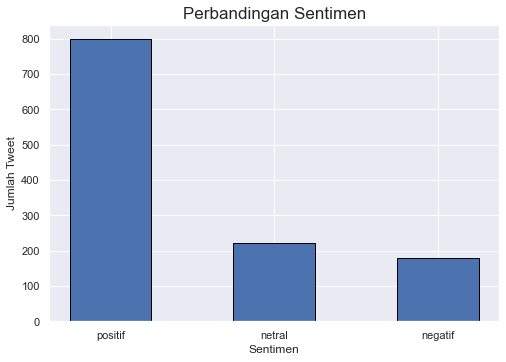

In [117]:
sns.set(style="darkgrid")
plt.figure(figsize=(7,5))

# hitung frekuensi dari masing-masing nilai pada kolom 'Produk'
class_freq = data_twt['label_prediksi'].value_counts()
# membuat bar plot dengan method `plt.bar()` dari matplotlib
plt.bar(x=class_freq.index, height=class_freq.values, align='center',  edgecolor = 'black', width= 0.5)
plt.title('Perbandingan Sentimen', size=17)
plt.tight_layout()
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Tweet')

plt.savefig('dataset uji/grafik batang.png', dpi=200)
plt.show()

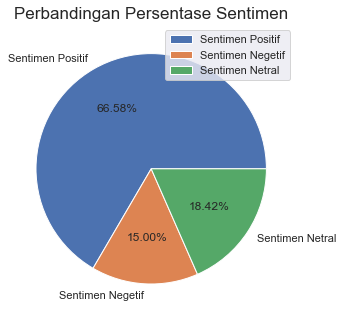

In [118]:
sentimen = ['Sentimen Positif', 'Sentimen Negetif', 'Sentimen Netral'] 
slices = [(data_twt['label_prediksi'] == "positif").sum(), (data_twt['label_prediksi'] == "negatif").sum(), (data_twt['label_prediksi'] == "netral").sum()] 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(slices,labels=sentimen,autopct='%1.2f%%')
fig = plt.gcf()
fig.set_size_inches(4,4) 
plt.title('Perbandingan Persentase Sentimen', size=17)
plt.legend()
plt.savefig('dataset uji/grafik pie.png', bbox_inches='tight', dpi=200)
plt.show()

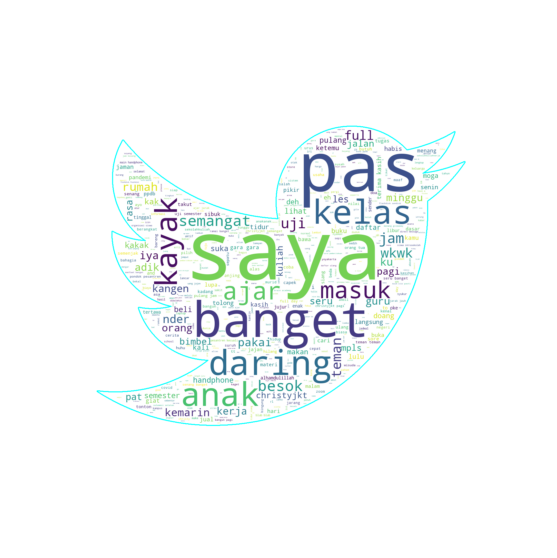

In [119]:
twitter_mask = np.array(Image.open("assets/twitter-logo.png"))

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

transformed_twitter_mask = np.ndarray((twitter_mask.shape[0],twitter_mask.shape[1]), np.int32)
for i in range(len(twitter_mask)):
    transformed_twitter_mask[i] = list(map(transform_format, twitter_mask[i]))

tweet_positif = data_twt[data_twt['label_prediksi'] == 'positif']
all_text_positif = ' '.join(word for word in tweet_positif['tweet_bersih'])
wordcloud = WordCloud(width=1000, height=1000, background_color='White',
                      mask=transformed_twitter_mask, max_words=1000,
                      contour_width=3, contour_color='aqua', stopwords=['sekolah', 'offline']).generate(all_text_positif)
wordcloud.to_file('dataset uji/wc-positif.png')

plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

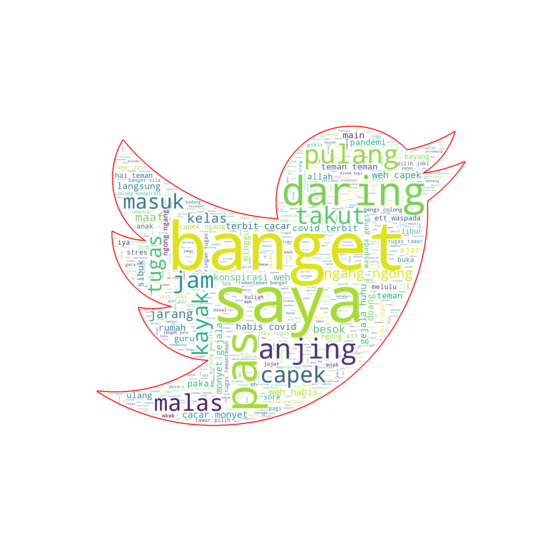

In [120]:
tweet_negatif = data_twt[data_twt['label_prediksi'] == 'negatif']
all_text_negatif = ' '.join(word for word in tweet_negatif['tweet_bersih'])
wordcloud = WordCloud(width=1000, height=1000, background_color='White',
                      mask=transformed_twitter_mask, max_words=1000,
                      contour_width=3, contour_color='red', stopwords=['sekolah', 'offline']).generate(all_text_negatif)
wordcloud.to_file('dataset uji/wc-negatif.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

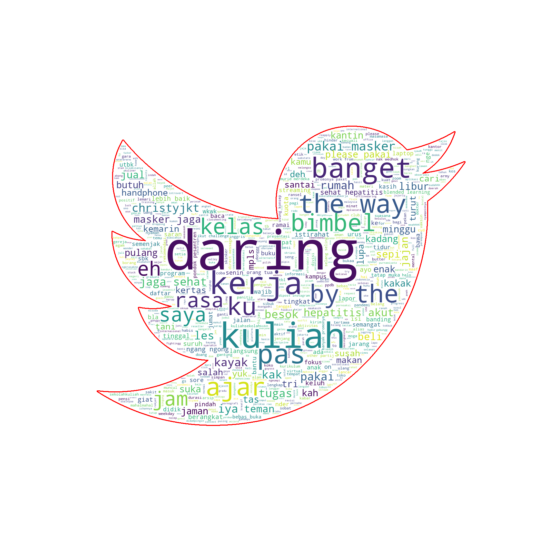

In [121]:
tweet_netral = data_twt[data_twt['label_prediksi'] == 'netral']
all_text_netral = ' '.join(word for word in tweet_netral['tweet_bersih'])
wordcloud = WordCloud(width=1000, height=1000, background_color='White',
                      mask=transformed_twitter_mask, max_words=1000,
                      contour_width=3, contour_color='red', stopwords=['sekolah', 'offline']).generate(all_text_netral)
wordcloud.to_file('dataset uji/wc-netral.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

In [129]:
data_twt[['tweet', 'label_prediksi']].head(10)

,tweet,label_prediksi
0,"kalo udah mulai normal lagi, udah pada sekolah...",positif
1,"pdhl brg2 jg glama pas msh offline, tau2 sekol...",negatif
2,[cm] kalo sidang offline berkas² pas penelitia...,positif
3,"@subschfess campur². ada senengnya, cnth kl ke...",negatif
4,gue dulu pacaran uwunya masih era offline nder...,positif
5,Syapa yg bingung takut nilai geblog karna tbtb...,positif
6,@schfess transisi sekolah online ke sekolah of...,netral
7,@samsungID BANYAK BANGET KENANGAN SEKOLAH OFFL...,positif
8,@vheyvhii wkwkwkwkwk sekolah kali ah offline,positif
9,@samsungID #ThankYouGalaxyJ udah nemenin jaman...,netral


In [122]:
filename = 'dataset uji/hasil-klasifikasi.csv'
data_twt.to_csv(filename, columns=['tweet', 'label_prediksi'], index=False)